Author: Emmanuel Rodriguez

https://emmanueljrodriguez.com/

Date: 25-Feb-2023, 11:52

Location: Seattle, WA

# Deep Learning for Timeseries

### Applying recurrent neural networks (RNNs) to a temperature forecasting example

Understand: "[Unlike other data types] Working with timeseries involves understanding the *dynamics* of a system - its periodic cycles, how it trends over time, its regular regime and its sudden spikes."

Ref: Chollet, 10.2 A temperature-forecasting example

Requirements: Develop a program that predicts the temperature 24 hours in the future.

Background: A dataset in the form of a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, which was recorded over the recent past by a set of sensors located at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany will be used in this analysis.

Ref: https://www.bgc-jena.mpg.de/wetter/

[Map of Max-Planck-Institute for Biogeochemistry](https://www.google.com/maps/place/Max+Planck+Institute+for+Biogeochemistry/@50.8995996,11.5482639,13z/data=!4m6!3m5!1s0x47a6a8e8b03dc12f:0x4ca4590c808f462f!8m2!3d50.9101246!4d11.5667919!16zL20vMGdnX3Nt) 

**To Do**

1. Understand the *for* loop logic under parse the data
2. Investigate the `timeseries_dataset_from_array()` function and the associated logic in the same cell block

### Step 1. Acquire

Load the dataset - download and uncompress the data.

In [8]:
# Recall: Using an '!' before the command will pass the command to the shell/command prompt (not to the Python interpreter)
!pip install wget 

# "pip Install Packages" is a tool for installing Python packages and their dependencies in a secure manner

In [15]:
!python -m wget -o jena_climate_2009_2016.csv.zip https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip 
    # wget is a windows network utility to retrieve files from the web
#!unzip jena_climate_2009_2016.csv.zip


Saved under jena_climate_2009_2016.csv.zip


Was running into issues with using 'wget'; https://stackoverflow.com/questions/60760049/wget-is-not-recognized-as-an-internal-or-external-command-operable-program-or-b

In [16]:
!unzip jena_climate_2009_2016.csv

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### Step 2. Prepare

Inspect the data of the Jena weather dataset

In [17]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parse the data**

Parse - data parsing is converting data from one format to another; it is generally done to make the existing, often unstructured data more comprehensible.

In [32]:
# Convert all lines of data into NumPy arrays: one array for the temperature, and another
# for the rest of the data - the features used to predict future temperatures. 
# Discard the 'Date Time' column.

import numpy as np
temp = np.zeros((len(lines),)) # Initialize the temp variable with an array of zeros of shape: lines x 0
raw_data = np.zeros((len(lines), len(header) - 1)) # Initialize the variable that will hold the features with zeros
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temp[i] = values[1]
    raw_data[i, :] = values[:]

In [33]:
#help(enumerate)

Visualize - Plot the temperature timeseries

Text(0.5, 1.0, 'Temperature over the full temporal range of the dataset (degC)')

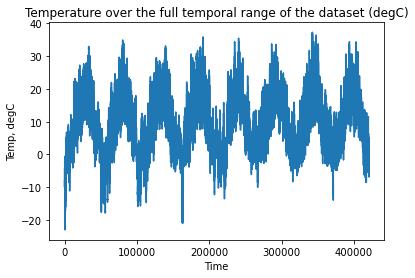

In [37]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp)), temp)
plt.xlabel('Time')
plt.ylabel('Temp, degC')
plt.title('Temperature over the full temporal range of the dataset (degC)')

On this plot, one can clearly see the yearly periodicity of temperature, the data spans 8 years.

In [39]:
# The data's sample rate is every 10 minutes, so how many data points per day?
# 6 samples per hour, so
daily_samples = 24 * 6

Text(0, 0.5, 'Temp, degC')

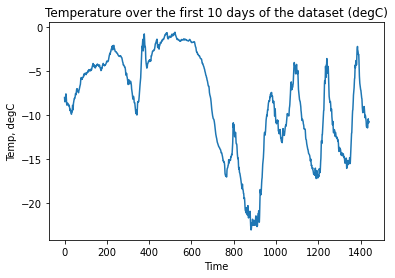

In [41]:
plt.plot(range(daily_samples*10), temp[:daily_samples*10])
plt.title('Temperature over the first 10 days of the dataset (degC)')
plt.xlabel('Time')
plt.ylabel('Temp, degC')

Cold weather! Note the daily periodicity, especially the last 4 days.
**Always look for periodicity in your data**

### Step 3. Analyze Data

Note: When working with timeseries data, it's important to use validation and test data that is more recent than the training data. This is because you want the model to have been trained with sufficient historical data, enough that it captures the periodicity - and when it comes times to test your model's performance, it is wise to use more recent data to increase the probability of making an accurate prediction of the future.

**Split the data into training, testing, and validation.**
* 50% for training
* 25% for testing
* 25% for validation

In [50]:
num_train_samples = int(0.5*len(raw_data)) # use the int() method to return an integer object, otherwise you would get a float - for a number of samples, you want an integer
num_test_samples = int(0.25*len(raw_data))
num_val_samples = len(raw_data) - num_train_samples - num_test_samples
print("num_train_samples:", num_train_samples)
print("num_test_samples:", num_test_samples)
print("num_val_samples:", num_val_samples)

num_train_samples: 210225
num_test_samples: 105112
num_val_samples: 105114


**Preprocess the data to a format a neural network can ingest.**

Each timeseries in the data is on a different scale, so they must be *normalized* so that each timeseries takes small values on a similar scale.

Normalize the training data:

In [52]:
mean = raw_data[:num_train_samples].mean(axis=0) # Slice into the raw_data array by starting at row 0 and stopping at the number of training samples
# by setting the axis parameter to '0', this will take the mean of the rows
raw_data -= mean # subtract the mean from every sample, and make this your new raw_data array
std = raw_data[:num_train_samples].std(axis=0) # calculate the standard deviation of the *new* raw_data array
raw_data /= std

# Assignment operators
# -=, x-=3 --> same as x=x-3
# /=, x/=3 --> same as x=x/3

Create a `Dataset` object that yields batches of data from the past five days along with a target temperature 24 hours in the future; this is to conserve memory.

Samples will be generated on the fly while only keeping the original `raw_data` and `temp[erature]` arrays; the built-in dataset utility in Keras `timeseries_dataset_from_array()` will perform this function.

> `timeseries_dataset_from_array()` will be used to instantiate three datasets: one for training, one for validation, and one for testing.

In [54]:
from tensorflow import keras

In [56]:
# Investigate the `timeseries_dataset_from_array()` function with dummy data first

int_sequence = np.arange(10) # Generates an array of sorted integers in the range of 0 to 9 (the 10 is excluded)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3], # The sequence generated will be sampled from [0 1 2 3 4 5 6]
    targets=int_sequence[3:], # The target for the sequence that starts at data[N] will be data[N+3]
    sequence_length=3, # The sequence will be 3 steps long
    batch_size=2, # The sequences will be batched in batches of size 2
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


# I need to gain an understanding of the above logic...

**Instantiate datasets for training, validation, and testing**

Instantiate - verb. represent as an instance

In [59]:
sampling_rate = 6 # One data point per hour
sequence_length = 120 # Observations go back 5 days (120 hours)
delay = sampling_rate * (sequence_length + 24 - 1) # The target for a sequence will be the temperature 24 hours
# after the end of the sequence.

batch_size = 256 # Arbitrary

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temp[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Each dataset yields a tuple `(samples, targets)`, where `samples` is a batch of 256 samples, each containing 120 consecutive hours of input data, and `targets` is the corresponding array of 256 target temperatures.

In [60]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine learning baseline

> Establish a baseline that *should* be beaten in order to demonstrate the usefulness of more-advanced machine learning models.

The temperature timeseries is assumed to be continuous as well as periodical with a daily period; thus, the common-sense approach says to predict the temperature 24 hours from now will be equal to the temperature right now.

This approach will be evaluated using the **mean absolute error (MAE)** metric, defined as
> `np.mean(np.abs(preds - targets))`

### Compute the common-sense baseline MAE

In [65]:
# Evaluation loop

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:,-1,1] * std[1] + mean[1] # Retrieve the last temperature measurement in the input sequence, which
        # is located at column 1 of the temperature feature; then 'un-normalize' it by multiplying the std dev and 
        # adding the mean
        total_abs_err += np.sum(np.abs(preds - targets)) # '+=' is an Assignment Operator equivalent to-> 
        # total_abs_err = total_abs_err + np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


In [72]:
baseline_val_MAE = evaluate_naive_method(val_dataset)
baseline_test_MAE = evaluate_naive_method(test_dataset)

In [73]:
print(f"Validation MAE: {baseline_val_MAE:.2f}")
print(f"Test MAE: {baseline_test_MAE:.2f}")

Validation MAE: 2.44
Test MAE: 2.62


The common-sense baseline achieves a validation MAE of 2.44$^\circ$C and a test MAE of 2.62$^\circ$C.

So, if it is assumed that the temperature 24 hours in the future is the same as it is now, then according to the MAE metric(s) calculated - we will be off by ~2.5$^\circ$ on average. - This becomes the number that we should *beat* with a deep learning model.

### Small bet: Try a simple, cheap ML model prior to looking into complicated and computationally expensive models such as RNNs

Train and evaluate a densely connected model.

> Note: Mean squared error (MSE) is used as the loss, rather than MAE, because unlike MAE, it's smooth around zero, which is a useful property for gradient descent. MAE will be monitored by adding it as a metric in `compile()`.

In [67]:
from tensorflow.keras import layers # from the Keras API, import the layers API

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras',
                                   save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                   epochs=10,
                   validation_data=val_dataset,
                   callbacks=callbacks)

model = keras.models.load_model('jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 10s 8ms/step - loss: 21.5858 - mae: 3.5730 - val_loss: 13.1326 - val_mae: 2.8540
Epoch 2/10
819/819 [==============================] - 6s 8ms/step - loss: 10.8367 - mae: 2.6021 - val_loss: 11.5916 - val_mae: 2.6857
Epoch 3/10
819/819 [==============================] - 6s 8ms/step - loss: 9.2235 - mae: 2.3965 - val_loss: 11.2935 - val_mae: 2.6484
Epoch 4/10
819/819 [==============================] - 6s 8ms/step - loss: 8.4994 - mae: 2.3022 - val_loss: 13.0697 - val_mae: 2.8660
Epoch 5/10
819/819 [==============================] - 6s 8ms/step - loss: 8.0802 - mae: 2.2463 - val_loss: 11.1098 - val_mae: 2.6391
Epoch 6/10
819/819 [==============================] - 6s 8ms/step - loss: 7.8307 - mae: 2.2108 - val_loss: 10.9581 - val_mae: 2.6227
Epoch 7/10
819/819 [==============================] - 6s 8ms/step - loss: 7.5687 - mae: 2.1774 - val_loss: 11.8938 - val_mae: 2.7381
Epoch 8/10
819/819 [==============================] - 7s 8ms/step 

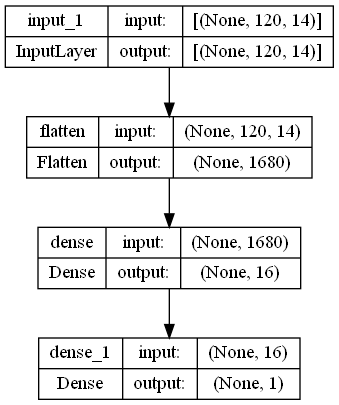

In [75]:
# Visualize the Neural Network:
keras.utils.plot_model(model, show_shapes=True)

>This is a fully connected model that starts by flattening the data and then runs it through two `Dense` layers. Note the lack of an activation function on the last `Dense` layer, which is typical for a regression problem.

Plot the results

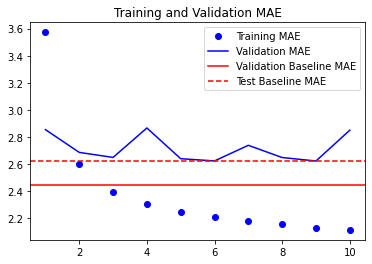

In [74]:
import matplotlib.pyplot as plt
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")

# Plot horizontal line for common-sense baseline(s)
plt.axhline(y=baseline_val_MAE, color='r', linestyle='-', label='Validation Baseline MAE') # val_dataset
plt.axhline(y=baseline_test_MAE, color='r', linestyle='--', label='Test Baseline MAE') # test_dataset baseline

plt.title("Training and Validation MAE")
plt.legend()
plt.show()

The goal is to beat the baseline MAE, i.e., the losses should be less (below) the horizontal lines. 

The validation MAE losses are close to the validation baseline, and even closer to the test baseline, but not reliably.

>In other words, there is merit in having this baseline in the first place, and it turns out not to be easy to outperform.

This begs the question, if a well-performing model exists to go from the data to the targets, i.e., the common-sense baseline; why doesn't the neural network (the two-layer densely connected model) being trained find it (and improve on it)?

* The common-sense heuristic is just one model among millions that can be represented in a hypothesis space.
* The hypothesis space, the space of models in which a solution is being searched for, is the space of all possible two-layer networks with the configuration defined.

> Just because a good solution technically exists in your hypothesis space doesn't mean you'll be able to find it via gradient descent.

> Unless the learning algorithm is hardcoded to look for a specific kind of simple model, it can sometimes fail to find a simple solution to a simple problem. Which is why, leveraging good feature engineering and relevant architecture priors is *essential*.

### 1D Convolutional Model

A convolutional model *could* work.

> A temporal convnet could reuse the same representations across different days, much like a spatial convnet can reuse the same representations across different locations in an image.

The `Conv1D` layer sees its inputs through 1D windows that slide across input sequences.

* This layer is a good fit for any sequence data that follows the **translation invariance assumption** - meaning, if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window.

In [77]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_conv.keras',
                                   save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                   epochs=10,
                   validation_data=val_dataset,
                   callbacks=callbacks)

model = keras.models.load_model('jena_conv.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 21s 24ms/step - loss: 22.1769 - mae: 3.7129 - val_loss: 16.0722 - val_mae: 3.1658
Epoch 2/10
819/819 [==============================] - 20s 24ms/step - loss: 15.4168 - mae: 3.1131 - val_loss: 14.4408 - val_mae: 3.0045
Epoch 3/10
819/819 [==============================] - 20s 24ms/step - loss: 13.6985 - mae: 2.9304 - val_loss: 15.2541 - val_mae: 3.0911
Epoch 4/10
819/819 [==============================] - 21s 25ms/step - loss: 12.7046 - mae: 2.8213 - val_loss: 15.6203 - val_mae: 3.1005
Epoch 5/10
819/819 [==============================] - 20s 25ms/step - loss: 12.0313 - mae: 2.7464 - val_loss: 18.1334 - val_mae: 3.3763
Epoch 6/10
819/819 [==============================] - 20s 25ms/step - loss: 11.5197 - mae: 2.6868 - val_loss: 15.5530 - val_mae: 3.1227
Epoch 7/10
819/819 [==============================] - 21s 25ms/step - loss: 11.1242 - mae: 2.6381 - val_loss: 14.2071 - val_mae: 2.9821
Epoch 8/10
819/819 [============================

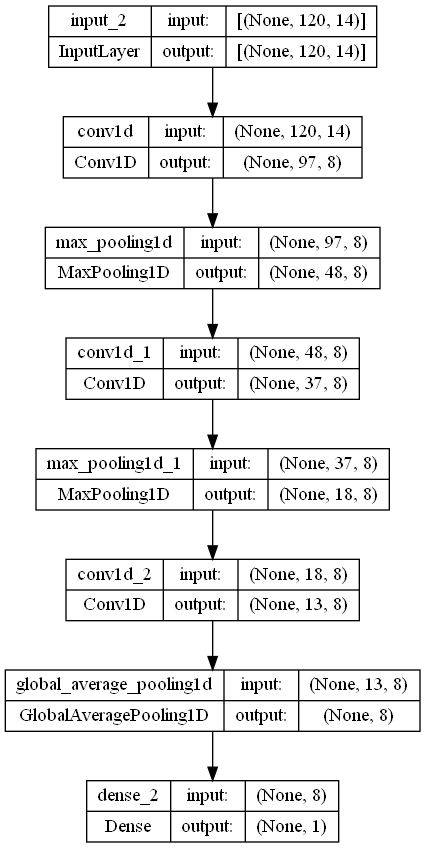

In [78]:
# Visualize the Neural Network:
keras.utils.plot_model(model, show_shapes=True)

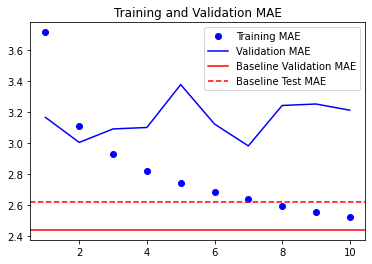

In [79]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")

# Plot horizontal line for common-sense baseline(s)
plt.axhline(y=baseline_val_MAE, color='r', linestyle='-', label='Baseline Validation MAE') # val_dataset
plt.axhline(y=baseline_test_MAE, color='r', linestyle='--', label='Baseline Test MAE') # test_dataset baseline

plt.title("Training and Validation MAE")
plt.legend()
plt.show()

3/4/23 22:27... this one performed even worse...

Next: 10.2.5 A first recurrent baseline

In [51]:
help(-=)

SyntaxError: invalid syntax (<ipython-input-51-100e954d9a10>, line 1)

In [46]:
type(num_train_samples)

int

In [49]:
num_train_samples

210225.5

In [27]:
enumerate?

References 

Chollet, F. (2021). Deep Learning with Python (2nd ed.). New York: Manning Publications Co. LLC.